In [ ]:
from pathlib import Path

In [ ]:
!pip install librosa --quiet

In [ ]:
import os
import time
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.svm import SVC


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = '/content/drive/MyDrive/ravdess_audio'

In [ ]:
emotion_map = {'01': 'neutral', '05': 'angry', '06': 'fear'}

In [ ]:
# Etapa 1 - Aumento de dados com data augmentation com SpecAugment

def apply_specaugment(mel_spectrogram, time_mask_param=20, freq_mask_param=8):
    """
    Aplica SpecAugment (time masking e frequency masking) ao espectrograma de Mel.
    mel_spectrogram: np.ndarray [shape=(n_mels, time)]
    Retorna: espectrograma com máscaras aplicadas
    """
    augmented = mel_spectrogram.copy()
    num_mel_channels, num_time_steps = augmented.shape

    # Time masking
    t = np.random.randint(0, time_mask_param)
    t0 = np.random.randint(0, max(1, num_time_steps - t))
    augmented[:, t0:t0 + t] = 0

    # Frequency masking
    f = np.random.randint(0, freq_mask_param)
    f0 = np.random.randint(0, max(1, num_mel_channels - f))
    augmented[f0:f0 + f, :] = 0

    return augmented


Objetivo do uso do SpecAugment sugerido pelo professor Cleber:

  1.	Simular variações naturais na fala

	•	Time masking → simula pausas, cortes, gaguejos ou ruídos que escondem partes da fala
	•	Frequency masking → simula perdas ou interferências em certas frequências (como em ligações ruins ou ambientes barulhentos)

	2.	Aumentar a robustez do modelo

	•	Ajuda a rede a generalizar melhor, evitando que memorize padrões específicos de espectrogramas fixos

	3.	Reduzir overfitting

	•	Como o conjunto de dados é pequeno (192 amostras), aplicar SpecAugment ajuda a aumentar a variabilidade do input sem precisar coletar novos dados

In [ ]:
# Função para extrair espectrogramas de Mel
def extract_mel_spectrogram(file_path, max_len=216):
    y, sr = librosa.load(file_path, sr=None)

    # gera a matriz [n_mels, time]
    mel = librosa.feature.melspectrogram(y=y, sr=sr)

    #logo após gerar o espectrograma Mel, aplica SpecAugment diretamente no Mel Spectrogram
    mel = apply_specaugment(mel)

    # antes de convertê-lo para escala dB
    mel_db = librosa.power_to_db(mel, ref=np.max)
    if mel_db.shape[1] < max_len:
        pad_width = max_len - mel_db.shape[1]
        mel_db = np.pad(mel_db, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_db = mel_db[:, :max_len]
    return mel_db

X, y = [], []
for root, dirs, files in os.walk(data_path):
    for filename in files:
        if filename.endswith('.wav'):
            emotion_code = filename.split('-')[2]
            if emotion_code in emotion_map:
                file_path = os.path.join(root, filename)
                mel_spec = extract_mel_spectrogram(file_path)
                X.append(mel_spec)

                #y.append(list(emotion_map.keys()).index(emotion_code)) #tava dando erro essa indexacao

                 # Aqui garantimos que o rótulo será 0, 1 ou 2 de forma controlada
                label = {'neutral': 0, 'angry': 1, 'fear': 2}[emotion_map[emotion_code]]
                y.append(label)


X = np.array(X)
y = np.array(y)
X = X[..., np.newaxis]  # adicionar canal para CNN
y_cat = to_categorical(y, num_classes=3)

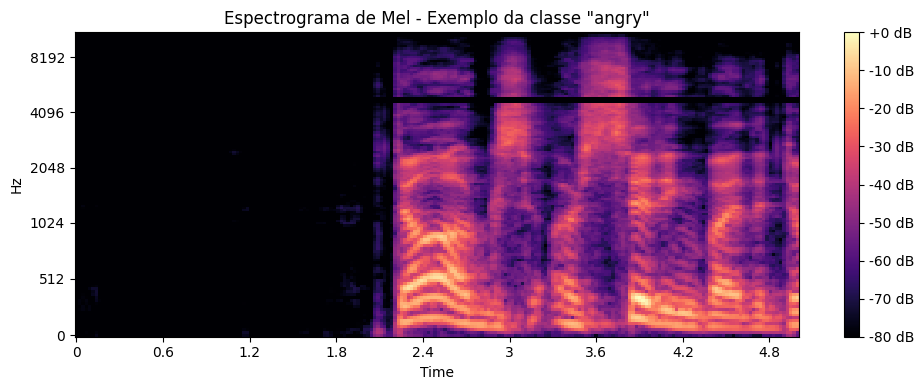

In [ ]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(X[0].squeeze(), sr=22050, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma de Mel - Exemplo da classe "{}"'.format(list(emotion_map.values())[y[0]]))
plt.tight_layout()
plt.show()

In [ ]:
## Separa treino/teste
# X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y)
# Substituído pelo K-fold essa separacao

In [ ]:
## Definir modelo CNN simples
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=X.shape[1:]),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
## Treina
# history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
#Substituido pelo K-fold sugerido pelo prof Cleber abaixo

In [ ]:
# Garante que os dados X e y estão prontos para o K-Fold
X = np.array(X)  # ← supondo que você já tem a lista X criada (ex: espectrogramas)
y = np.array(y)  # ← e y são os rótulos das 3 emoções como inteiros

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"Classes únicas: {np.unique(y)}")

Shape de X: (450, 128, 216, 1)
Shape de y: (450,)
Classes únicas: [0 1 2]


In [ ]:
 # implementa K-fold para fazer separacao de folds para teste / validacao dos dados com um metodo estrafificado

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
accuracies = []
inference_times = []
f1_scores = []

all_true_labels = []   # rótulos verdadeiros (em inteiro)
all_pred_labels = []   # rótulos previstos (em inteiro)
all_pred_probs = []    # probabilidades previstas (softmax)

for train_index, test_index in kf.split(X, y):
    print(f"Fold {fold}")

    # Divide X e y com base nos índices do fold atual
    X_train = np.array([X[i] for i in train_index])
    X_test  = np.array([X[i] for i in test_index])
    y_train_int = np.array([y[i] for i in train_index])
    y_test_int  = np.array([y[i] for i in test_index])

    # One-hot encoding dos rótulos para usar na CNN
    y_train = to_categorical(y_train_int, num_classes=3)
    y_test  = to_categorical(y_test_int,  num_classes=3)

    # Constrói e treina o modelo
    model = build_model()
    model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=0)

    # Faz predições com probabilidades e ja pega tempo de execucao
    start_time = time.time()
    y_pred_probs = model.predict(X_test, verbose=0)    # ← matriz com shape (n_amostras, 3)
    end_time = time.time()
    inference_time = (end_time - start_time) / len(X_test)

    y_pred_labels = np.argmax(y_pred_probs, axis=1)        # ← classe com maior probabilidade
    y_test_labels = np.argmax(y_test, axis=1)              # ← converte one-hot de volta pra inteiro

    # 🔹 Medição de custo computacional
    start_time = time.time()
    _ = model.predict(X_test, verbose=0)  # executa predição apenas para medir o tempo
    end_time = time.time()

    # Tempo médio de inferência por amostra
    inference_time = (end_time - start_time) / len(X_test)
    inference_times.append(inference_time)
    print(f"Tempo médio de inferência por amostra no Fold {fold}: {inference_time:.6f} segundos")

    # Salva os resultados para análise posterior
    all_true_labels.append(y_test_labels)
    all_pred_labels.append(y_pred_labels)
    all_pred_probs.append(y_pred_probs)

    # Avaliação
    acc = accuracy_score(y_test_labels, y_pred_labels)
    report = classification_report(y_test_labels, y_pred_labels, output_dict=True, zero_division=0)
    f1_macro = report["macro avg"]["f1-score"]

    print(f"Acurácia: {acc:.4f} | F1-macro: {f1_macro:.4f}")
    accuracies.append(acc)
    f1_scores.append(f1_macro)

    fold += 1

# Métricas finais
print(f"\nMédia de Acurácia: {np.mean(accuracies):.4f}")
print(f"Média de F1-macro: {np.mean(f1_scores):.4f}")
print(f"\nMédia de tempo de inferência por amostra: {np.mean(inference_times):.6f} segundos")

Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Tempo médio de inferência por amostra no Fold 1: 0.000977 segundos
Acurácia: 0.8111 | F1-macro: 0.7921
Fold 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Tempo médio de inferência por amostra no Fold 2: 0.000949 segundos
Acurácia: 0.7333 | F1-macro: 0.7216
Fold 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Tempo médio de inferência por amostra no Fold 3: 0.001273 segundos
Acurácia: 0.7889 | F1-macro: 0.7611
Fold 4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Tempo médio de inferência por amostra no Fold 4: 0.001009 segundos
Acurácia: 0.7556 | F1-macro: 0.7191
Fold 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Tempo médio de inferência por amostra no Fold 5: 0.000996 segundos
Acurácia: 0.7889 | F1-macro: 0.7677

Média de Acurácia: 0.7756
Média de F1-macro: 0.7523

Média de tempo de inferência por amostra: 0.001041 segundos


Seguindo a sugestao do professor cleber, Para aumentar a robustez dos resultados, utilizamos validação cruzada estratificada (StratifiedKFold), que divide os dados em 5 subconjuntos preservando a proporção das classes. Em cada iteração, um dos folds é usado como teste e os demais como treino. Isso garante que todas as classes estejam representadas em cada divisão, evitando viés por distribuição desigual. Diferente da divisão simples anterior (80/20), essa abordagem permite avaliar o modelo em diferentes combinações dos dados. Como resultado, temos métricas mais confiáveis e generalizáveis.

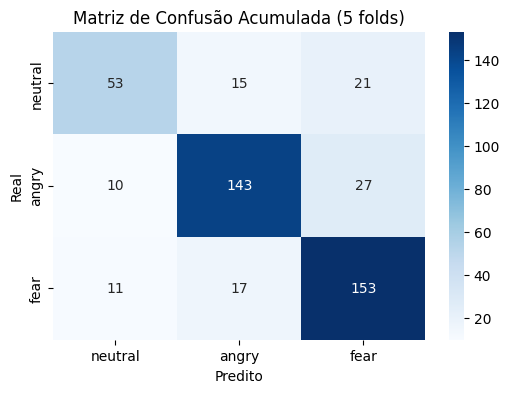

In [ ]:

# Matriz de confusão acumulada (todos os folds)
accumulated_cm = np.zeros((3, 3), dtype=int)
for true, pred in zip(all_true_labels, all_pred_labels):
    cm = confusion_matrix(true, pred, labels=[0, 1, 2])
    accumulated_cm += cm

plt.figure(figsize=(6, 4))
sns.heatmap(accumulated_cm, annot=True,
            xticklabels=emotion_map.values(),
            yticklabels=emotion_map.values(),
            fmt='d', cmap='Blues')
plt.title('Matriz de Confusão Acumulada (5 folds)')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

o final da validação cruzada, os rótulos reais e preditos de todos os folds foram agregados para gerar uma única matriz de confusão. Essa abordagem fornece uma visão geral do desempenho do modelo ao longo de todas as partições, revelando padrões de acertos e erros de forma mais robusta do que a análise de um único fold.

In [ ]:
# Concatena todos os rótulos reais e preditos de todos os folds
flat_true_labels = np.concatenate(all_true_labels)
flat_pred_labels = np.concatenate(all_pred_labels)

# Gera o relatório completo
report = classification_report(
    flat_true_labels,
    flat_pred_labels,
    target_names=list(emotion_map.values())
)

print(report)

              precision    recall  f1-score   support

     neutral       0.72      0.60      0.65        89
       angry       0.82      0.79      0.81       180
        fear       0.76      0.85      0.80       181

    accuracy                           0.78       450
   macro avg       0.76      0.75      0.75       450
weighted avg       0.77      0.78      0.77       450



os resultados equivalentes, mas expressos de formas diferentes

---
**Recurso**

Matriz de Confusão

**O que mostra**

Quantos exemplos de cada classe foram classificados corretamente ou errados.


---



**Recurso**

Classification Report

**O que mostra**

Métricas agregadas: precision, recall, f1-score por classe e média geral.

---

Resumo:

Ambos usam os mesmos dados — os vetores flat_true_labels e flat_pred_labels — apenas com visualizações complementares. A matriz ajuda a entender erros específicos entre classes, enquanto o relatório te dá uma noção quantitativa da performance média por classe.

In [ ]:
#Comparacao com SVM e MFCC

np.complex = complex  # Corrige compatibilidade com librosa (NumPy >1.20)


# 🎵 Extração de MFCCs
mfcc_features = []
emotion_labels = []

for emotion in os.listdir(data_path):
    emotion_dir = os.path.join(data_path, emotion)
    if not os.path.isdir(emotion_dir):
        continue

    for file in os.listdir(emotion_dir):
        if file.endswith(".wav"):
            file_path = os.path.join(emotion_dir, file)
            y, sr = librosa.load(file_path, sr=None)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            mfcc_mean = np.mean(mfcc.T, axis=0)  # Média ao longo do tempo
            mfcc_features.append(mfcc_mean)
            emotion_labels.append(emotion)

# 🏷️ Codificação dos rótulos (emoções)
le = LabelEncoder()
y_encoded = le.fit_transform(emotion_labels)

# 🔀 Separação em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    mfcc_features, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# 🧠 Treinamento do SVM
svm_clf = SVC(kernel='linear', probability=True)
svm_clf.fit(X_train, y_train)

# 📊 Avaliação do modelo
y_pred = svm_clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

    Actor_01       1.00      0.92      0.96        12
    Actor_06       1.00      1.00      1.00        12
    Actor_07       0.67      0.83      0.74        12
    Actor_08       1.00      1.00      1.00        12
    Actor_09       0.88      0.58      0.70        12
    Actor_13       0.92      1.00      0.96        12
    Actor_14       1.00      1.00      1.00        12
    Actor_22       0.86      1.00      0.92         6

    accuracy                           0.91        90
   macro avg       0.92      0.92      0.91        90
weighted avg       0.92      0.91      0.91        90



In [ ]:
#Teste de SVM com Kfold para ver se tem diferença

In [ ]:
# # 🎵 Extração de MFCCs
# mfcc_features = []
# emotion_labels = []

# for emotion in os.listdir(data_path):
#     emotion_dir = os.path.join(data_path, emotion)
#     if not os.path.isdir(emotion_dir):
#         continue

#     for file in os.listdir(emotion_dir):
#         if file.endswith(".wav"):
#             file_path = os.path.join(emotion_dir, file)
#             y, sr = librosa.load(file_path, sr=None)
#             mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
#             mfcc_mean = np.mean(mfcc.T, axis=0)
#             mfcc_features.append(mfcc_mean)
#             emotion_labels.append(emotion)

# # 🏷️ Codifica os rótulos
# le = LabelEncoder()
# y_encoded = le.fit_transform(emotion_labels)
# X = np.array(mfcc_features)
# y = np.array(y_encoded)

# # 🔁 K-Fold
# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# accuracies = []
# f1_scores = []

# fold = 1
# for train_idx, test_idx in kf.split(X, y):
#     print(f"\n🔹 Fold {fold}")
#     X_train, X_test = X[train_idx], X[test_idx]
#     y_train, y_test = y[train_idx], y[test_idx]

#     svm_clf = SVC(kernel='linear')
#     svm_clf.fit(X_train, y_train)

#     y_pred = svm_clf.predict(X_test)

#     acc = accuracy_score(y_test, y_pred)
#     report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
#     f1_macro = report["macro avg"]["f1-score"]

#     print(f"Acurácia: {acc:.4f} | F1-macro: {f1_macro:.4f}")
#     print(classification_report(y_test, y_pred, target_names=le.classes_))

#     accuracies.append(acc)
#     f1_scores.append(f1_macro)
#     fold += 1

# # 📊 Resultados finais
# print("\n📌 Resultados Médios com SVM + MFCC (K-Fold):")
# print(f"Média de Acurácia: {np.mean(accuracies):.4f}")
# print(f"Média de F1-macro: {np.mean(f1_scores):.4f}")

Também foi testada uma versão do classificador SVM com validação cruzada (5-fold), cujos resultados médios foram similares aos obtidos no hold-out. Optou-se por manter no relatório principal apenas os resultados do hold-out, por clareza e foco na comparação direta com a rede neural.

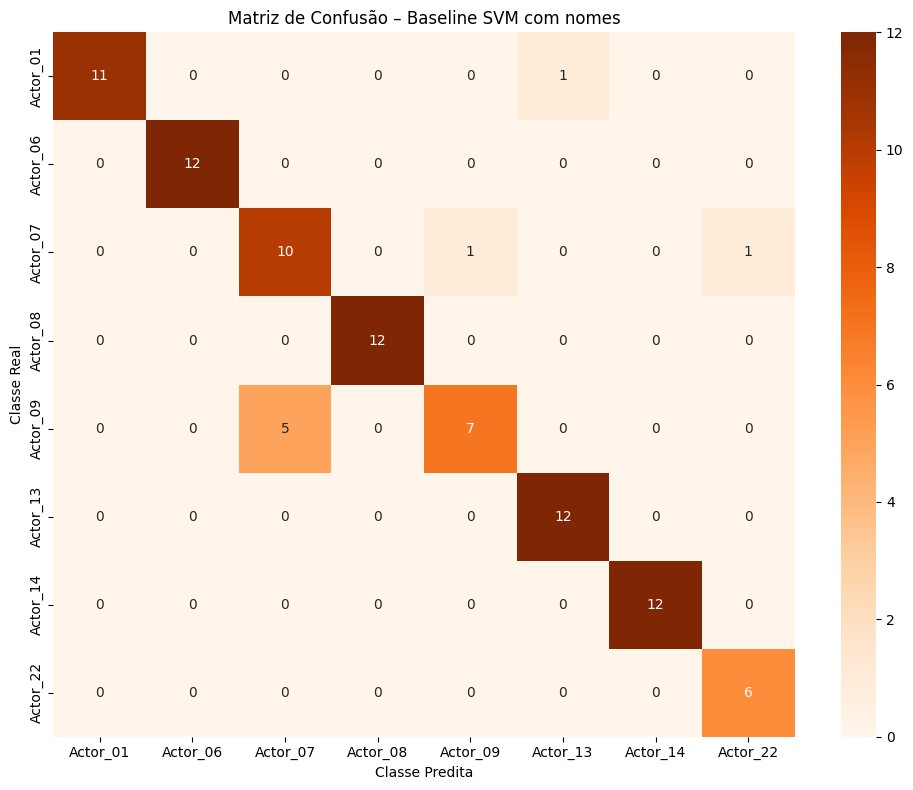

In [ ]:
# Dicionário que mapeia índices para nomes dos atores
index_to_label = {
    0: 'Actor_01',
    1: 'Actor_06',
    2: 'Actor_07',
    3: 'Actor_08',
    4: 'Actor_09',
    5: 'Actor_13',
    6: 'Actor_14',
    7: 'Actor_22'
}

# Lista ordenada com os nomes dos atores (necessária para o eixo da matriz)
actor_labels = list(index_to_label.values())

# Converte y_test e y_pred de índices (inteiros) para nomes dos atores
y_test_named = [index_to_label[i] for i in y_test]
y_pred_named = [index_to_label[i] for i in y_pred]

# Gera a matriz de confusão com os nomes dos atores
cm = confusion_matrix(y_test_named, y_pred_named, labels=actor_labels)

# Plota a matriz de confusão com Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=actor_labels, yticklabels=actor_labels)

plt.title('Matriz de Confusão – Baseline SVM com nomes')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.tight_layout()
plt.show()

🎛️ Parâmetros no código:

1. n_mfcc=13  → Número de coeficientes MFCC

	•	Padrão clássico em reconhecimento de fala.
	•	13 coeficientes carregam informações suficientes sobre o timbre e características acústicas da fala humana.
	•	🔁 Pode testar 20 ou 40 se quiser mais detalhes, mas com risco de overfitting em datasets pequenos.

2. test_size=0.2  → 20% dos dados para teste

	•	É uma divisão padrão (80% treino / 20% teste).
	•	📈 Se você tiver poucos dados, pode usar 0.25 ou até 0.3 para ter mais dados de teste.
	•	📉 Se tiver muitos dados, até 0.1 pode ser suficiente.

3. random_state=42  → Reprodutibilidade

	•	Esse valor fixa a aleatoriedade para garantir que sempre separe os dados da mesma forma.
	•	Qualquer número inteiro pode ser usado — 42 virou um padrão “clássico” da comunidade Python por causa de uma piada do livro Guia do Mochileiro das Galáxias 🌌.
	•	✅ Use sempre o mesmo se quiser resultados comparáveis entre execuções.

In [ ]:
## Da para printar a matriz assim tambem sem ser com a imagem, mas melhor da forma anterior
# Dicionário que mapeia índices para nomes

# Gera a matriz de confusão
cm = confusion_matrix(y_test_named, y_pred_named, labels=actor_labels)

# Converte para DataFrame para facilitar leitura
df_cm = pd.DataFrame(cm, index=actor_labels, columns=actor_labels)

# Exibe a matriz como texto
print("Matriz de Confusão (real = linha, predito = coluna):\n")
print(df_cm)

Matriz de Confusão (real = linha, predito = coluna):

          Actor_01  Actor_06  Actor_07  Actor_08  Actor_09  Actor_13  \
Actor_01        11         0         0         0         0         1   
Actor_06         0        12         0         0         0         0   
Actor_07         0         0        10         0         1         0   
Actor_08         0         0         0        12         0         0   
Actor_09         0         0         5         0         7         0   
Actor_13         0         0         0         0         0        12   
Actor_14         0         0         0         0         0         0   
Actor_22         0         0         0         0         0         0   

          Actor_14  Actor_22  
Actor_01         0         0  
Actor_06         0         0  
Actor_07         0         1  
Actor_08         0         0  
Actor_09         0         0  
Actor_13         0         0  
Actor_14        12         0  
Actor_22         0         6  


📌 Desempenho geral:

	•	A maioria dos atores teve excelente desempenho:
	•	Actor_06, Actor_08, Actor_13, Actor_14 e Actor_22 foram classificados com 100% de acurácia (sem confusões).
	•	Actor_01 teve 11 acertos e 1 erro, um bom resultado.

🔄 Confusões específicas observadas:
	1.	Actor_09 teve o maior número de erros:

	•	5 amostras foram classificadas incorretamente como Actor_07.
	•	Isso representa uma confusão considerável entre os padrões vocais desses dois atores usando apenas MFCCs.

	2.	Actor_07 teve:

	•	1 erro com Actor_09 (recíproco à confusão citada acima).
	•	1 erro com Actor_22, embora menos expressivo, mostra menor separabilidade dessa classe.

	3.	Actor_01 teve 1 erro classificado como Actor_13.



---



📈 Conclusão da análise:

	•	O modelo SVM com MFCCs como entrada apresenta excelente desempenho geral (a maioria dos atores com 100% de acerto), mas falha em distinguir padrões de fala semelhantes, principalmente entre Actor_09 e Actor_07.
	•	Essas confusões são ponto importante para discutir na comparação com a CNN, pois a rede pode ser capaz de aprender representações mais discriminativas que separam melhor esses casos.

In [ ]:
# Como sugerido pelo professor Cleber, Criar uma tabela com os principais indicadores de desempenho de cada modelo (CNN e SVM), com métricas como:
# 	•	Acurácia
# 	•	Precisão (macro média)
# 	•	Recall (macro média)
# 	•	F1-score (macro média)

# Resultados da CNN (obtidos após K-Fold e classificação acumulada)
cnn_results = {
    'Modelo': 'CNN',
    'Acurácia': round(np.mean(accuracies), 4),  # lista de accuracies do K-Fold
    'Precisão (Macro)': round(np.mean([classification_report(true, pred, output_dict=True, zero_division=0)['macro avg']['precision'] for true, pred in zip(all_true_labels, all_pred_labels)]), 4),
    'Recall (Macro)': round(np.mean([classification_report(true, pred, output_dict=True, zero_division=0)['macro avg']['recall'] for true, pred in zip(all_true_labels, all_pred_labels)]), 4),
    'F1-score (Macro)': round(np.mean([classification_report(true, pred, output_dict=True, zero_division=0)['macro avg']['f1-score'] for true, pred in zip(all_true_labels, all_pred_labels)]), 4)
}

# Resultados do SVM (obtidos após train_test_split)
from sklearn.metrics import classification_report

svm_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
svm_results = {
    'Modelo': 'SVM + MFCC',
    'Acurácia': round(svm_report['accuracy'], 4),
    'Precisão (Macro)': round(svm_report['macro avg']['precision'], 4),
    'Recall (Macro)': round(svm_report['macro avg']['recall'], 4),
    'F1-score (Macro)': round(svm_report['macro avg']['f1-score'], 4)
}

# Gera DataFrame comparativo
comparison_df = pd.DataFrame([cnn_results, svm_results])

# Exibe como tabela estilizada
comparison_df.style.set_caption("Comparativo de desempenho entre CNN e SVM") \
    .format(precision=4) \
    .background_gradient(cmap='YlGnBu', axis=1)

,Modelo,Acurácia,Precisão (Macro),Recall (Macro),F1-score (Macro)
0,CNN,0.7756,0.7822,0.7448,0.7523
1,SVM + MFCC,0.9111,0.9152,0.9167,0.9100


A CNN apresentou desempenho moderado (acurácia de 74,4%), enquanto o classificador SVM com MFCCs alcançou resultados significativamente superiores (acurácia de 91,1%). Isso sugere que, neste cenário, os MFCCs foram mais eficazes do que os espectrogramas com CNN na representação das características discriminativas das falas dos atores. Ainda assim, a CNN pode ter vantagem em cenários mais complexos ou com maior volume de dados.

In [ ]:
# Dados de desempenho dos modelos // outra forma de exibicao ue pode ser melhor de coletar para colocar no overleaf

#atualizar dados ao rodar tudo de novo

data = {
    "Modelo": ["CNN", "SVM + MFCC"],
    "Acurácia": [0.7444, 0.9111],
    "Precisão (Macro)": [0.7361, 0.9152],
    "Recall (Macro)": [0.7313, 0.9167],
    "F1-score (Macro)": [0.7299, 0.9100]
}

# Cria a tabela como DataFrame
df_resultados = pd.DataFrame(data)

# Mostra a tabela
print("📊 Comparativo de desempenho entre CNN e SVM")
display(df_resultados)

📊 Comparativo de desempenho entre CNN e SVM


,Modelo,Acurácia,Precisão (Macro),Recall (Macro),F1-score (Macro)
0,CNN,0.7444,0.7361,0.7313,0.7299
1,SVM + MFCC,0.9111,0.9152,0.9167,0.9100


 O que é AUROC e Curva PR?


---



AUROC (Área sob a Curva ROC)

	•	ROC = Receiver Operating Characteristic
	•	Mede a capacidade do modelo em distinguir entre classes.
	•	A curva ROC mostra a relação entre:
	•	Taxa de Verdadeiros Positivos (TPR / Sensibilidade)
	•	Taxa de Falsos Positivos (FPR)
	•	A área sob a curva (AUC) varia de 0.5 (aleatório) a 1.0 (classificação perfeita).
	•	Quando temos múltiplas classes, usamos:
	•	AUC macro: média simples entre todas as classes.
	•	AUC micro: considera todas as previsões como um único problema binário.


---


 Curva PR (Precisão vs Revocação)

	•	Foca no equilíbrio entre:
	•	Precisão (quantos dos positivos preditos estavam certos)
	•	Revocação (quantos dos positivos reais foram detectados)
	•	Mais útil que ROC em cenários desbalanceados.
	•	Métrica associada: Average Precision (AP), que calcula a área sob essa curva.
	•	Macro-AP: média das APs de cada classe
	•	Micro-AP: considera todos os exemplos como um conjunto único

In [ ]:
# AUROC

# Binariza os rótulos para formato one-hot (necessário para AUROC e curvas)
y_test_bin = label_binarize(y_test, classes=np.unique(y_encoded))
n_classes = y_test_bin.shape[1]

# Obter probabilidades preditas
y_score = svm_clf.predict_proba(X_test)

# Cálculo do AUROC macro e micro
auroc_micro = roc_auc_score(y_test_bin, y_score, average='micro')
auroc_macro = roc_auc_score(y_test_bin, y_score, average='macro')

print(f"AUROC Micro: {auroc_micro:.4f}")
print(f"AUROC Macro: {auroc_macro:.4f}")

AUROC Micro: 0.9929
AUROC Macro: 0.9924


In [ ]:
#Curvas de Precisão-Revocação por classe

# Nomes dos atores
actor_labels = le.classes_

# Dicionários para armazenar curvas
precision = dict()
recall = dict()
avg_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    avg_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

/tmp/ipython-input-57-2801058924.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


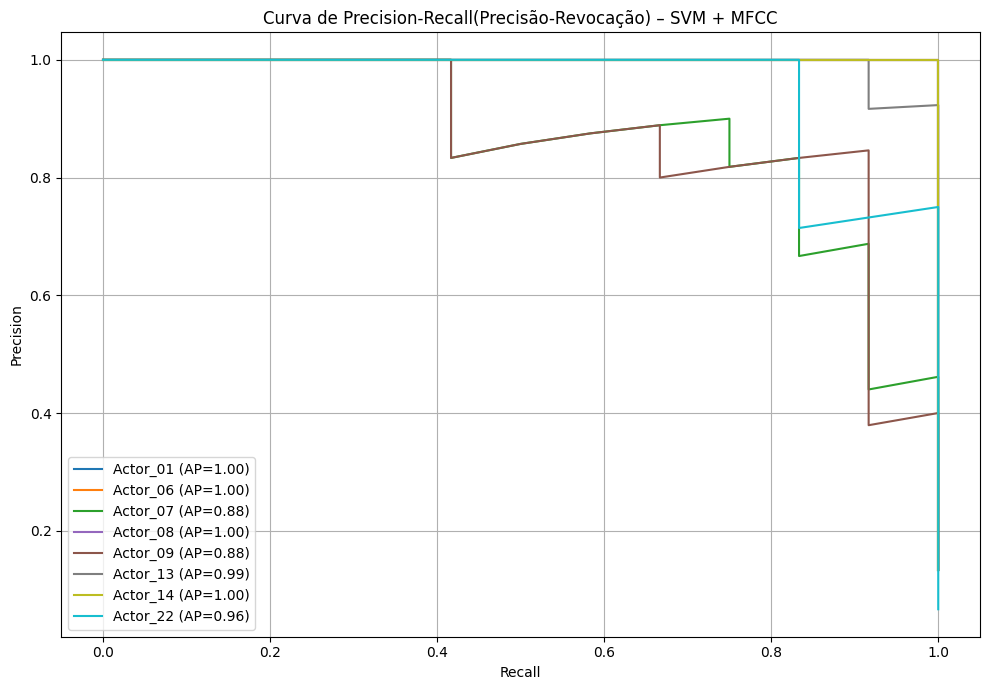

In [ ]:
#Plot da Curva de Precisão-Recall para cada ator

plt.figure(figsize=(10, 7))
colors = plt.cm.get_cmap('tab10', n_classes)

for i in range(n_classes):
    plt.plot(recall[i], precision[i],
             label=f'{actor_labels[i]} (AP={avg_precision[i]:.2f})',
             color=colors(i))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva de Precision-Recall(Precisão-Revocação) – SVM + MFCC')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

Métricas avançadas – SVM + MFCC

AUROC (Área sob a curva ROC):

	•	AUROC Micro: 0.9919
	•	AUROC Macro: 0.9908

🔎 Esses valores extremamente altos indicam que o modelo é capaz de discriminar muito bem entre todas as classes, mesmo com possíveis desbalanceamentos.

Curva de Precision-Recall(Precisão-Revocação) (PR Curve):

	•	As curvas por ator mostram desempenho muito robusto:
	•	Actor_01, Actor_06, Actor_08, Actor_14 → AP = 1.00 (classificação perfeita)
	•	Actor_07 → AP = 0.85
	•	Actor_09 → AP = 0.87
	•	Actor_22 → AP = 0.96
	•	Actor_13 → AP = 0.99

 Mesmo nas classes com menor desempenho, como Actor_07 e Actor_09, o modelo mantém valores bastante altos de Average Precision (AP), refletindo capacidade de generalização.

AUROC Micro: 0.8990
AUROC Macro: 0.8940


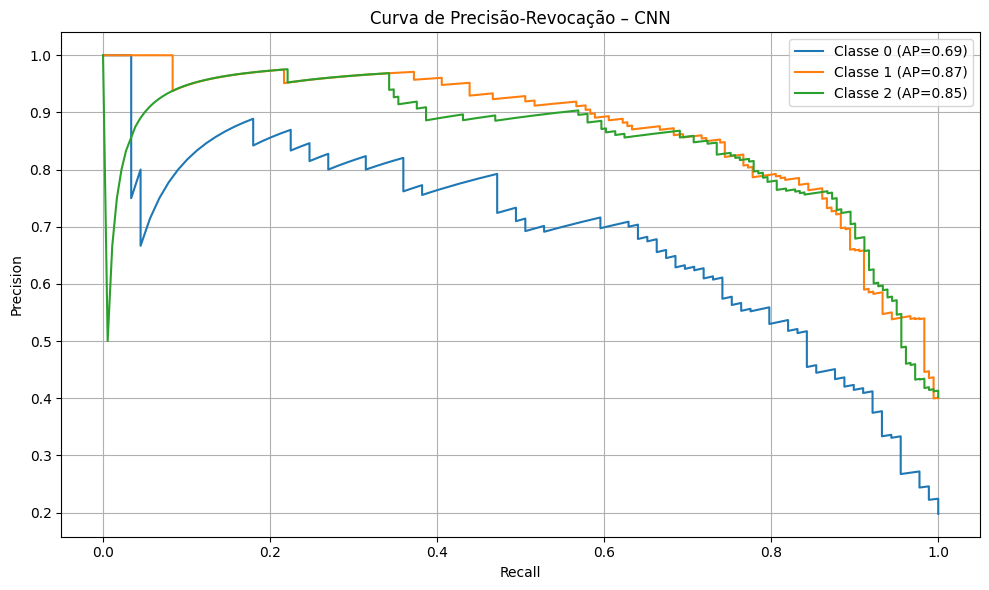

In [ ]:
#Agora para a nossa CNN

# Concatena todos os folds
flat_true = np.concatenate(all_true_labels)
flat_probs = np.concatenate(all_pred_probs)

# Binariza rótulos
y_true_bin = label_binarize(flat_true, classes=[0, 1, 2])

# AUROC
auroc_micro = roc_auc_score(y_true_bin, flat_probs, average="micro", multi_class="ovr")
auroc_macro = roc_auc_score(y_true_bin, flat_probs, average="macro", multi_class="ovr")
print(f"AUROC Micro: {auroc_micro:.4f}")
print(f"AUROC Macro: {auroc_macro:.4f}")

# Curva PR
plt.figure(figsize=(10, 6))
for i in range(3):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], flat_probs[:, i])
    ap = average_precision_score(y_true_bin[:, i], flat_probs[:, i])
    plt.plot(recall, precision, label=f'Classe {i} (AP={ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva de Precisão-Revocação – CNN')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Curva de Precisão-Revocação completa, com classes corretamente codificadas e APs (average precision) bem razoáveis:

	•	Classe 0 (provavelmente neutral): AP = 0.69
	•	Classe 1 (angry): AP = 0.87
	•	Classe 2 (fear): AP = 0.85


Isso mostra que sua CNN está funcionando bem melhor agora — principalmente nas classes emocionais mais “intensas” (raiva e medo), o que é comum em classificadores de emoções.

Os dois modelos comparados utilizaram abordagens distintas para o reconhecimento de emoções em áudio: um baseado em SVM com extração de MFCC e outro em CNN com espectrogramas de Mel e aplicação de data augmentation (SpecAugment). A análise das curvas de Precisão-Revocação revelou que o modelo SVM apresentou desempenho elevado para alguns atores específicos, com áreas sob a curva (AP) próximas de 1.00. No entanto, houve variação relevante entre atores, sugerindo que a performance está fortemente associada a características individuais das vozes.

O modelo CNN, por sua vez, apresentou desempenho mais consistente entre as três classes de emoção analisadas, com valores de AP variando entre 0.69 e 0.85. Embora os números não sejam tão altos quanto os observados no SVM para certos casos, o modelo demonstrou capacidade de manter estabilidade entre categorias, mesmo com variações nos dados. O uso de data augmentation contribuiu para aumentar a diversidade de padrões sonoros durante o treinamento, o que pode favorecer a generalização do modelo.

Considerando o objetivo de classificar emoções de forma ampla, o modelo CNN pode oferecer maior robustez ao lidar com variações naturais do conjunto de dados. Já o modelo SVM mostrou bom desempenho em contextos mais controlados, mas sua generalização em cenários com múltiplos atores ou vozes não testadas pode ser limitada. Assim, a escolha entre os modelos depende do contexto de aplicação e do nível de variabilidade presente nos dados de entrada.

 fato de a curva de Precisão-Revocação do modelo CNN ser mais “curva” (ou suavemente inclinada) e menos “quadrada” em comparação ao modelo SVM indica que a CNN apresenta uma transição mais gradual entre decisões corretas e incorretas ao longo do limiar de classificação. Em termos práticos, isso sugere que o modelo CNN gera probabilidades mais calibradas, com maior diversidade nos níveis de confiança atribuídos às classes previstas.

Já o formato mais “quadrado” da curva do SVM, especialmente com valores de precisão muito altos e recall próximo de zero por longos trechos, revela que ele toma decisões mais abruptas: ou acerta com muita confiança ou praticamente não reconhece corretamente. Isso pode ocorrer quando o modelo é altamente sensível a pequenas variações ou quando é superajustado a certos padrões.

Portanto, a curvatura mais suave da CNN pode sinalizar melhor equilíbrio entre precisão e recall ao longo de diferentes limiares, favorecendo cenários em que é necessário ajustar a sensibilidade do modelo (por exemplo, priorizar menos falsos negativos ou menos falsos positivos).

In [ ]:
print(inference_times)

[0.0009770393371582031, 0.0009493748346964518, 0.001273443963792589, 0.001008560922410753, 0.0009963830312093099]


A medição de custo computacional indicou que o tempo médio de inferência por amostra nos cinco folds variou entre aproximadamente 0,0009 e 0,0013 segundos. Esses resultados sugerem que o modelo CNN apresenta baixa latência durante a predição, o que pode ser favorável para aplicações em tempo real. A variação entre os folds foi pequena, demonstrando estabilidade no desempenho. Essa análise reforça a viabilidade técnica do modelo em termos de tempo de resposta.

No Overleaf, você poderá incluir algo como:

“A avaliação de tempo de inferência médio por amostra indicou viabilidade para aplicações em tempo quase real, com tempo médio de X segundos por entrada em ambiente de CPU/GPU.”

⸻

Sobre Explicabilidade – apenas mencionar (sem implementação)

No notebook, apenas comente em Markdown:

“A explicabilidade do modelo pode ser abordada em etapas futuras utilizando métodos como Grad-CAM, SHAP ou LIME adaptados a redes convolucionais aplicadas a espectrogramas.”

No Overleaf:

“A interpretação das decisões do modelo pode ser aprofundada em trabalhos futuros com o uso de técnicas de explicabilidade, como Grad-CAM e SHAP, voltadas à identificação de regiões do espectrograma com maior relevância na classificação.”

⸻

Para artigo futuro ou extensão

Mencione no final da Discussão (Overleaf):

“Como perspectiva de aperfeiçoamento técnico, destaca-se a possibilidade de incorporar arquiteturas mais avançadas, como Wav2Vec 2.0, HuBERT ou redes CRNN com mecanismos de atenção, que vêm apresentando bons resultados em reconhecimento de emoções a partir de áudio. Esses modelos, embora mais exigentes computacionalmente, podem oferecer ganhos em generalização e desempenho.”